In [ ]:
import numpy as np
import os

In [27]:
# load data, compute FC and build map of orig_matrix.
data_path = "../data"

echoes_orig_matrixs = {} # key: echo_num.  val: original_matrix of each echo (each row is a flat of FC).
for file in os.listdir(data_path):
    if "echo-" not in file: 
        continue
    subject_id = file[file.find("-")+1 : file.find("_")]
    echo_num = file[file.find("echo-")+5 : file.find("echo-")+6]
    data = np.genfromtxt(fname=os.path.join(data_path, file), dtype='float32', delimiter=' ')#.transpose()
    FC = np.corrcoef(data)
    mask = np.tril(np.full((FC.shape[0],FC.shape[0]), True, dtype=bool), -1)
    orig_column = FC[mask]
    orig_column = np.expand_dims(orig_column, axis=0)

    if echo_num in echoes_orig_matrixs:
        orig_matrix = echoes_orig_matrixs.get(echo_num)
        orig_matrix = np.concatenate((orig_matrix, orig_column))
        echoes_orig_matrixs.update({echo_num:orig_matrix})
    else:
        echoes_orig_matrixs.update({echo_num:orig_column})
        
print("success")

success


In [20]:
from scipy.stats import pearsonr
a = np.array([[1,4,3],[4,1,6]])
b = np.array([[2,1,5],[4,6,7]])
c = np.zeros((2,2))
for i in range(2): 
    for j in range(2): 
        c[i,j] = pearsonr(a[i,:],b[j,:]).statistic
c

array([[-0.05241424,  0.78571429],
       [ 0.92261291,  0.21677749]])

In [28]:
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
echo_nums = list(echoes_orig_matrixs.keys())
# for echo_num1 in echo_nums:
    # for echo_num2 in echo_nums:
# if echo_num1 is echo_num2: continue
echo_num1 = echo_nums[2]
echo_num2 = echo_nums[3]
orig_matrix1 = echoes_orig_matrixs.get(echo_num1)
orig_matrix2 = echoes_orig_matrixs.get(echo_num2)
subject_num = orig_matrix1.shape[0]
orig_matrix = np.concatenate((orig_matrix1, orig_matrix2))
max_numPCs = 2 * subject_num
mask_diag = np.diag(np.full(subject_num, True, dtype=bool))
PCA_comps_range = np.array(range(2,max_numPCs+1))

# Compute Identifiability matrix, original FCs
Ident_mat_orig = np.zeros((subject_num, subject_num))
for i in range(subject_num):
    for j in range(subject_num):
        Ident_mat_orig[i,j] = pearsonr(orig_matrix1[i,:], orig_matrix2[j,:]).statistic

# Ident_mat_orig = np.corrcoef(orig_matrix1, orig_matrix2, rowvar=False)
# Ident_mat_orig = Ident_mat_orig[:]
# Idiff computation, original FCs
Iself_orig = np.mean(Ident_mat_orig[mask_diag])
Iothers_orig = np.mean(Ident_mat_orig[~mask_diag])
Idiff_orig = (Iself_orig - Iothers_orig) * 100

# Differential Identifiability (Idiff) evaluation of PCA decomposition into FC-modes
Idiff_recon = np.zeros(max_numPCs)
for i in PCA_comps_range:
    pca = PCA(n_components=i)
    recon_matrix = pca.inverse_transform(pca.fit_transform(orig_matrix))
    recon_matrix1 = recon_matrix[0:subject_num,:]
    recon_matrix2 = recon_matrix[subject_num:,:]
    # Compute Identifiability matrix, reconstructed FCs with different number of PCs
    # Ident_mat_recon = np.corr(recon_matrix1, recon_matrix2, rowvar=False)
    Ident_mat_recon = np.zeros((subject_num, subject_num))
    for i in range(subject_num):
        for j in range(subject_num):
            Ident_mat_recon[i,j] = pearsonr(recon_matrix1[i,:], recon_matrix2[j,:]).statistic
    # Idiff computation, reconstructed FCs
    Iself_recon = np.mean(Ident_mat_recon[mask_diag])
    Iothers_recon = np.mean(Ident_mat_recon[~mask_diag])
    Idiff_recon[i-1] = (Iself_recon - Iothers_recon) * 100

# Identifiability matrix at optimal reconstruction
Idiff_opt = np.max(Idiff_recon)
m_star = PCA_comps_range[Idiff_recon[1:] == Idiff_opt][0]
pca = PCA(n_components=m_star)
recon_matrix_opt = pca.inverse_transform(pca.fit_transform(orig_matrix))
recon_matrix_opt1 = recon_matrix_opt[0:subject_num,:]
recon_matrix_opt2 = recon_matrix_opt[subject_num:,:]
# Compute Recon Identifiability matrix at optimal point
Ident_mat_recon_opt = np.zeros((subject_num, subject_num))
for i in range(subject_num):
    for j in range(subject_num):
        Ident_mat_recon_opt[i,j] = pearsonr(recon_matrix_opt1[i,:], recon_matrix_opt2[j,:]).statistic
# Ident_mat_recon_opt = np.corrcoef(recon_matrix_opt1, recon_matrix_opt2, rowvar=False)
    #     break
    # break

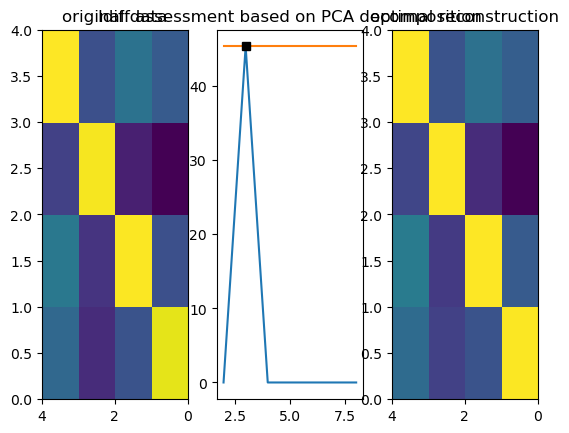

In [29]:
from matplotlib import pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
c = ax0.pcolor(Ident_mat_orig)
ax0.set_title('original data')
ax0.invert_xaxis()

c = ax1.plot(PCA_comps_range, Idiff_recon[1:])
ax1.plot(PCA_comps_range, Idiff_orig*np.ones(PCA_comps_range.size), )
ax1.plot(m_star, Idiff_opt, '-sk')
ax1.set_title('Idiff assessment based on PCA decomposition')

c = ax2.pcolor(Ident_mat_recon_opt)
ax2.set_title('optimal reconstruction')
ax2.invert_xaxis()

In [28]:
from sklearn.decomposition import PCA
a = np.array([[1,2,3,5],[6,4,3,2],[4,6,8,9],[2,4,6,8],[3,5,7,10]])
FC = np.corrcoef(a)
mask = np.tril(np.full((FC.shape[0],FC.shape[0]), True, dtype=bool),-1)
orig_matrix = FC[mask]
pca = PCA(n_components=2)
data_pca = pca.fit_transform(a)
res = pca.inverse_transform(data_pca)
res

array([[1.0361452 , 1.97023229, 2.96854154, 5.03666463],
       [5.95120612, 4.02466231, 3.0636989 , 1.94085664],
       [4.18820318, 5.90676257, 7.7517245 , 9.22929558],
       [2.08106195, 3.99278538, 5.84800217, 8.11923827],
       [2.74338355, 5.10555745, 7.36803288, 9.67394488]])